In [1]:
!pip install tensorflow keras

In [ ]:
backtest_strategy

In [2]:
import numpy as np
import pandas as pd
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class PairsTradingDQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.train_on_batch(state, target_f)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# This is just a basic outline. For a complete implementation, we would need to add functions to handle the pairs trading logic,
# data preprocessing, training loop, etc.


In [3]:
# !pip install yfinance

import yfinance as yf

start_date = "2020-01-01"  # Define tu fecha de inicio aquí
end_date = "2023-12-31"    # Define tu fecha de fin aquí

# Lista de pares
pairs = [
    ("MSFT", "JPM"),
    ("MSFT", "TXN"),
    ("JPM", "T"),
    ("JPM", "HON"),
    ("JPM", "GE"),
    ("JNJ", "WFC"),
    ("XOM", "CVX"),
    ("HON", "TXN"),
    ("GE", "TXN"),
]

data = {}

for stock1, stock2 in pairs:
    data[stock1] = yf.download(stock1, start=start_date, end=end_date)
    data[stock2] = yf.download(stock2, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
import numpy as np
import statsmodels.api as sm

def get_signal(stock1_data, stock2_data):
    # Calcular el spread entre los dos activos usando una regresión
    X = stock1_data['Close'].values
    Y = stock2_data['Close'].values
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    stock1_data['Spread'] = Y - model.predict(X)

    # Calcular la media y la desviación estándar del spread
    mean_spread = stock1_data['Spread'].mean()
    std_spread = stock1_data['Spread'].std()

    # Definir umbrales para señales de compra/venta
    z_upper = 1.0  # este valor puede ser ajustado
    z_lower = -1.0 # este valor puede ser ajustado

    upper_threshold = mean_spread + z_upper * std_spread
    lower_threshold = mean_spread + z_lower * std_spread

    # Crear señales de trading basadas en el spread
    stock1_data['Signal'] = 0
    stock1_data['Signal'][stock1_data['Spread'] > upper_threshold] = -1
    stock1_data['Signal'][stock1_data['Spread'] < lower_threshold] = 1

    return stock1_data['Signal']


D:\anaconda3\envs\tensorGPU\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\envs\tensorGPU\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


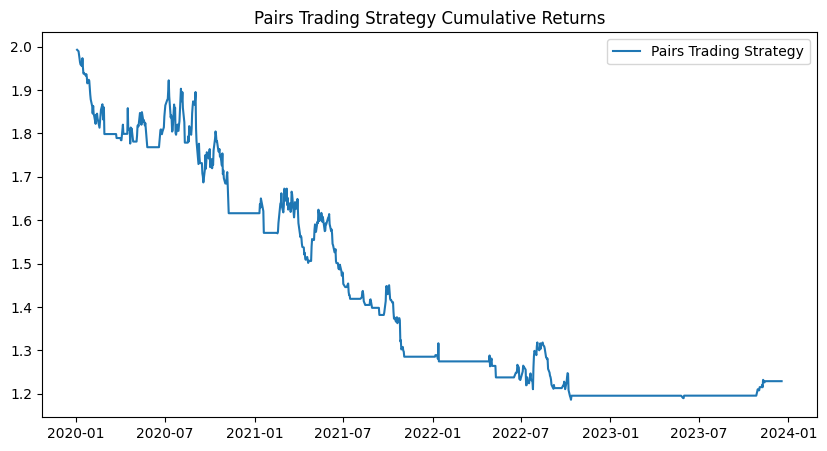

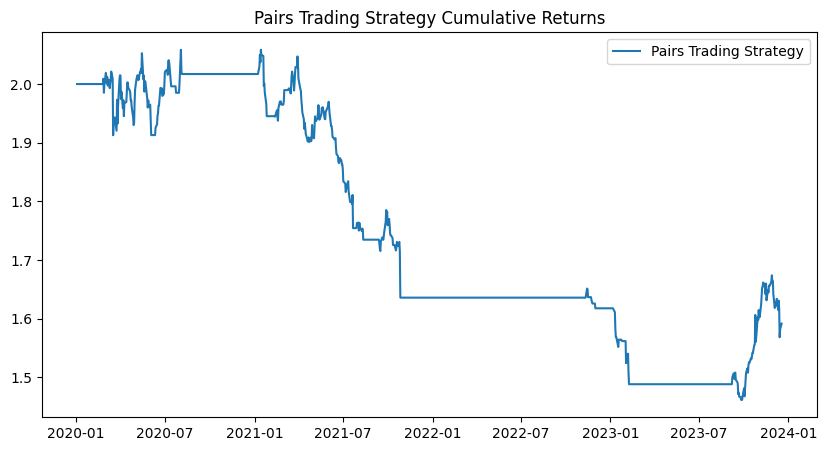

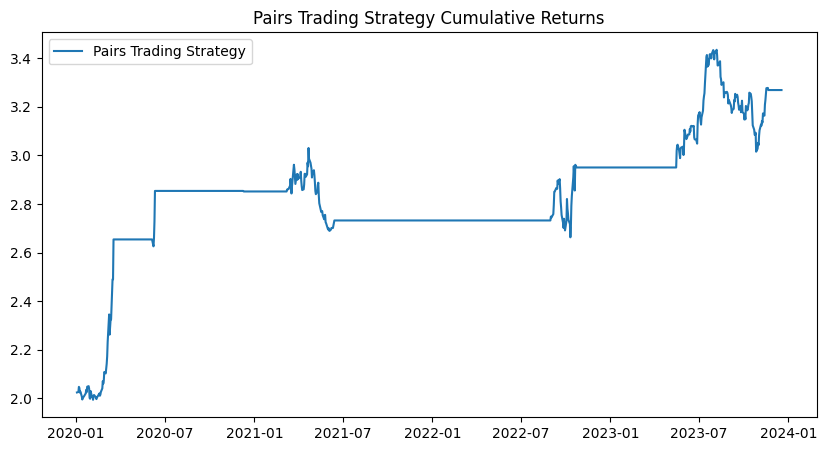

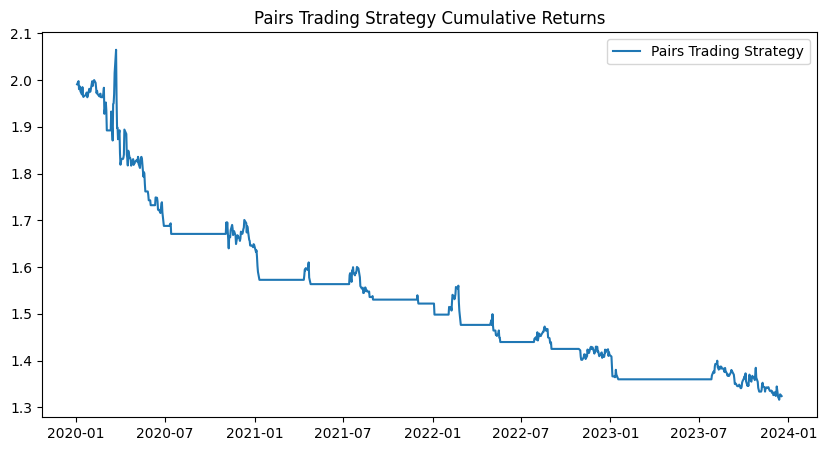

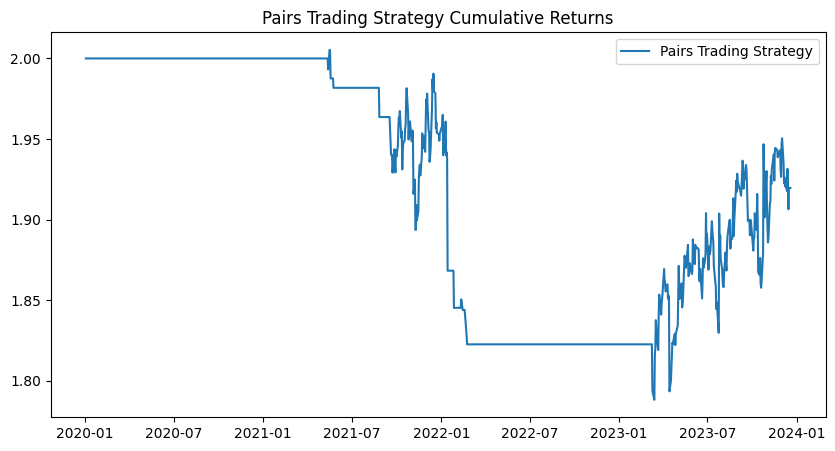

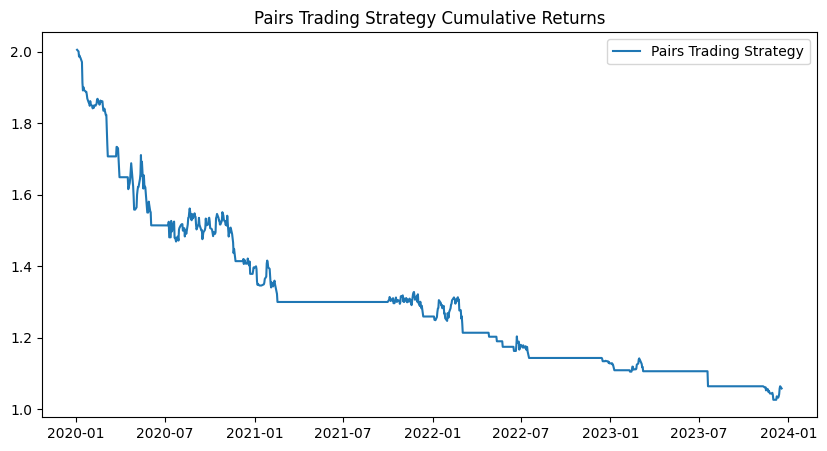

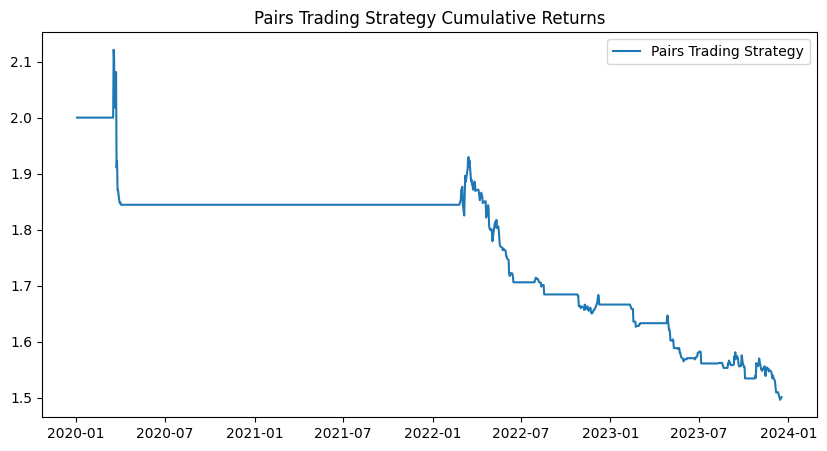

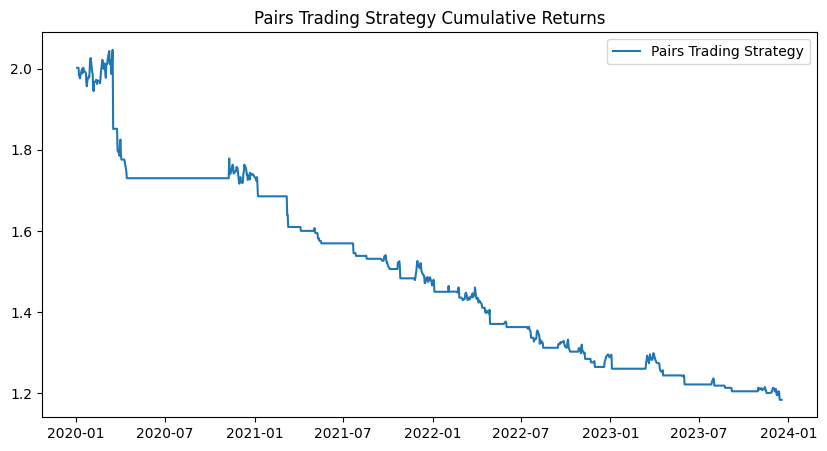

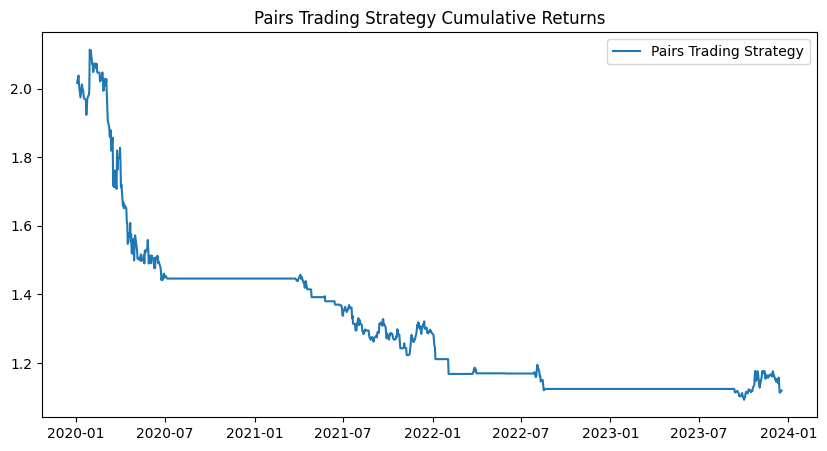

In [5]:
import matplotlib.pyplot as plt

def backtest_strategy(stock1_data, stock2_data, signals):
    # Calcular los rendimientos diarios
    stock1_data['Daily Return'] = stock1_data['Close'].pct_change() * signals.shift(1)
    stock2_data['Daily Return'] = -stock2_data['Close'].pct_change() * signals.shift(1)

    # Calcular el rendimiento acumulado
    stock1_data['Cumulative Return'] = (1 + stock1_data['Daily Return']).cumprod()
    stock2_data['Cumulative Return'] = (1 + stock2_data['Daily Return']).cumprod()
    portfolio_cumulative_return = stock1_data['Cumulative Return'] + stock2_data['Cumulative Return']

    # Visualizar el rendimiento acumulado
    plt.figure(figsize=(10,5))
    plt.plot(stock1_data.index, portfolio_cumulative_return, label="Pairs Trading Strategy")
    plt.legend()
    plt.title("Pairs Trading Strategy Cumulative Returns")
    plt.show()

# Ejemplo de uso
for stock1, stock2 in pairs:
    stock1_data = data[stock1]
    stock2_data = data[stock2]
    signals = get_signal(stock1_data, stock2_data)
    backtest_strategy(stock1_data, stock2_data, signals)


# EL MODELO

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training for pair MSFT/JPM completed!
Training for pair MSFT/TXN completed!
Training for pair JPM/T completed!
Training for pair JPM/HON completed!
Training for pair JPM/GE completed!


D:\anaconda3\envs\tensorGPU\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda3\envs\tensorGPU\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


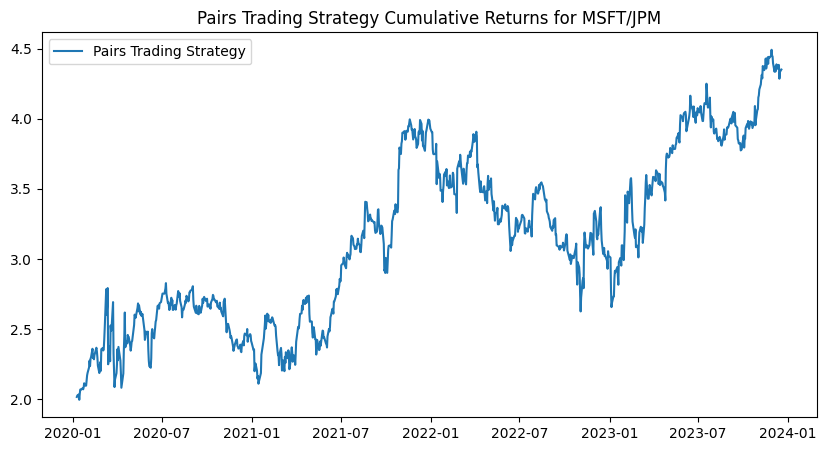

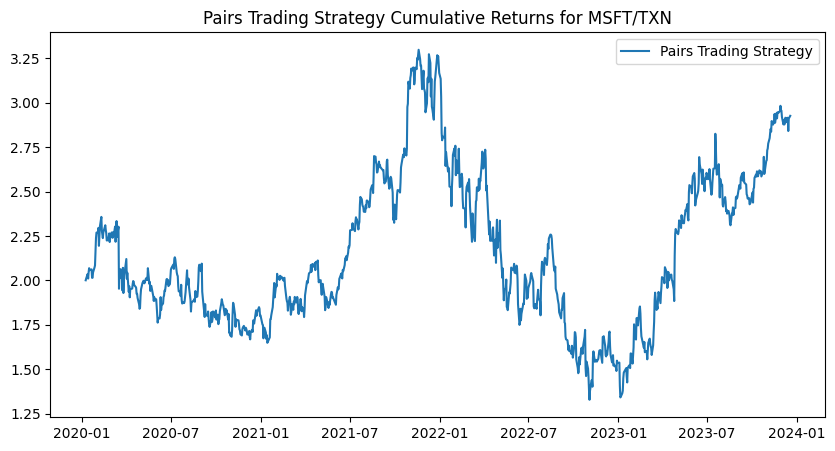

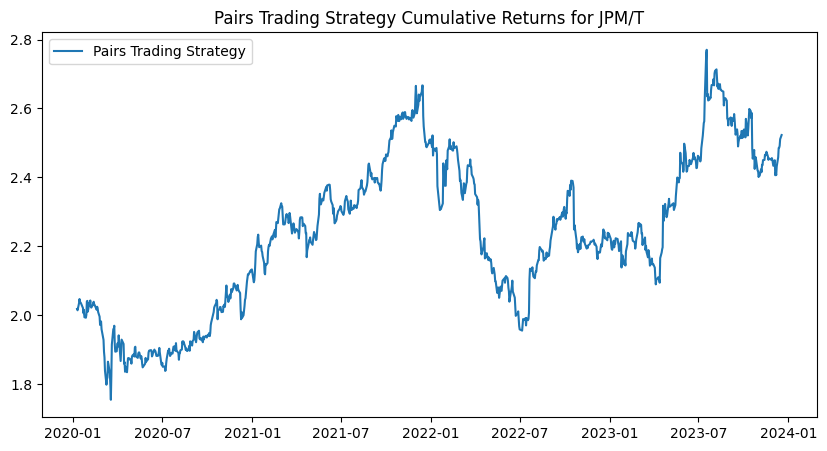

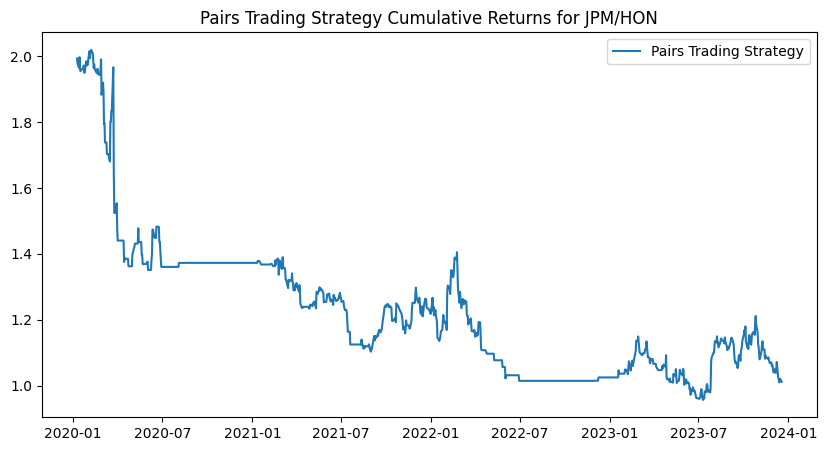

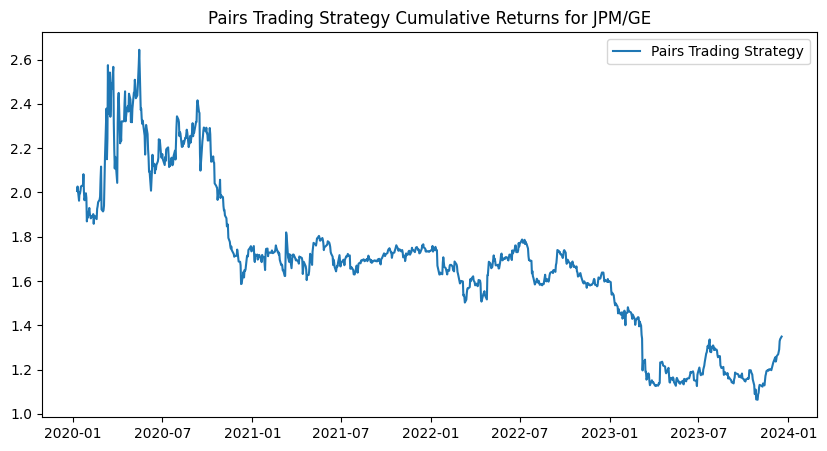

In [6]:
import yfinance as yf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 1. Descargar datos
start_date = "2020-01-01"
end_date = "2023-12-31"
pairs = [("MSFT", "JPM"), ("MSFT", "TXN"), ("JPM", "T"), ("JPM", "HON"), ("JPM", "GE")]

data = {}
for stock1, stock2 in pairs:
    data[stock1] = yf.download(stock1, start=start_date, end=end_date)
    data[stock2] = yf.download(stock2, start=start_date, end=end_date)

# 2. Definir el agente DQN
class PairsTradingDQN:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_size = 3  # 0: hold, 1: long stock1/short stock2, 2: short stock1/long stock2
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.train_on_batch(state, target_f)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 3. Entrenar el agente DQN
N = 5  # Window size for state
agent = PairsTradingDQN(2*N)
episodes = 200

for stock1, stock2 in pairs:
    stock1_data = data[stock1]['Close'].values
    stock2_data = data[stock2]['Close'].values

    for _ in range(episodes):
        state = np.concatenate([stock1_data[:N], stock2_data[:N]])
        state = np.reshape(state, [1, 2*N])
        total_reward = 0
        for t in range(N, len(stock1_data) - 1):
            action = agent.act(state)
            next_state = np.concatenate([stock1_data[t-N+1:t+1], stock2_data[t-N+1:t+1]])
            next_state = np.reshape(next_state, [1, 2*N])
            if action == 1:  # long stock1/short stock2
                reward = stock1_data[t+1] / stock1_data[t] - stock2_data[t+1] / stock2_data[t]
            elif action == 2:  # short stock1/long stock2
                reward = stock2_data[t+1] / stock2_data[t] - stock1_data[t+1] / stock1_data[t]
            else:
                reward = 0
            total_reward += reward
            done = True if t == len(stock1_data) - 2 else False
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.replay()
    print(f"Training for pair {stock1}/{stock2} completed!")

# 4. Generate trading signals
signals = {}
for stock1, stock2 in pairs:
    stock1_data = data[stock1]['Close'].values
    stock2_data = data[stock2]['Close'].values
    state = np.concatenate([stock1_data[:N], stock2_data[:N]])
    state = np.reshape(state, [1, 2*N])
    signal = []
    for t in range(N, len(stock1_data)):
        action = agent.act(state)
        signal.append(action)
        next_state = np.concatenate([stock1_data[t-N+1:t+1], stock2_data[t-N+1:t+1]])
        next_state = np.reshape(next_state, [1, 2*N])
        state = next_state
    signals[(stock1, stock2)] = signal

agent.model.save_weights("model_weights.h5")

# 5. Backtest
def backtest_strategy(stock1_data, stock2_data, signals):
    # Calculate daily returns
    stock1_data['Daily Return'] = stock1_data['Close'].pct_change()
    stock2_data['Daily Return'] = -stock2_data['Close'].pct_change()

    stock1_data['Strategy Return'] = np.nan
    stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)

    stock2_data['Strategy Return'] = np.nan
    stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)

    stock1_data['Cumulative Return'] = (1 + stock1_data['Strategy Return']).cumprod()
    stock2_data['Cumulative Return'] = (1 + stock2_data['Strategy Return']).cumprod()
    portfolio_cumulative_return = stock1_data['Cumulative Return'] + stock2_data['Cumulative Return']

    # Visualize cumulative returns
    plt.figure(figsize=(10,5))
    plt.plot(stock1_data.index[N:], portfolio_cumulative_return[N:], label="Pairs Trading Strategy")
    plt.legend()
    plt.title(f"Pairs Trading Strategy Cumulative Returns for {stock1}/{stock2}")
    plt.show()

# Run backtest
for stock1, stock2 in pairs:
    stock1_data = data[stock1].copy()
    stock2_data = data[stock2].copy()
    backtest_strategy(stock1_data, stock2_data, signals[(stock1, stock2)])


<ipython-input-3-e146cf9b6c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)
<ipython-input-3-e146cf9b6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)


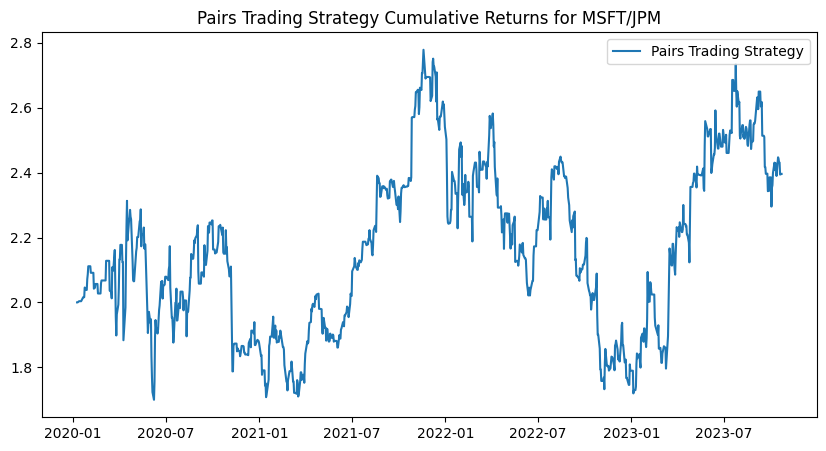

<ipython-input-3-e146cf9b6c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)
<ipython-input-3-e146cf9b6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)


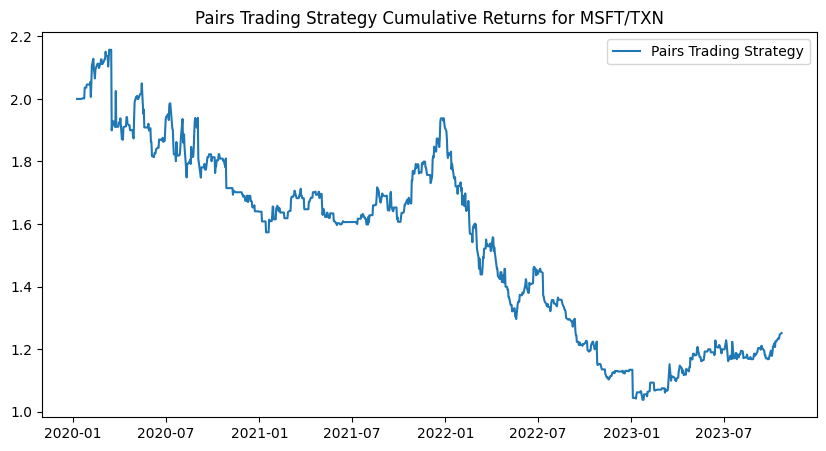

<ipython-input-3-e146cf9b6c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)
<ipython-input-3-e146cf9b6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)


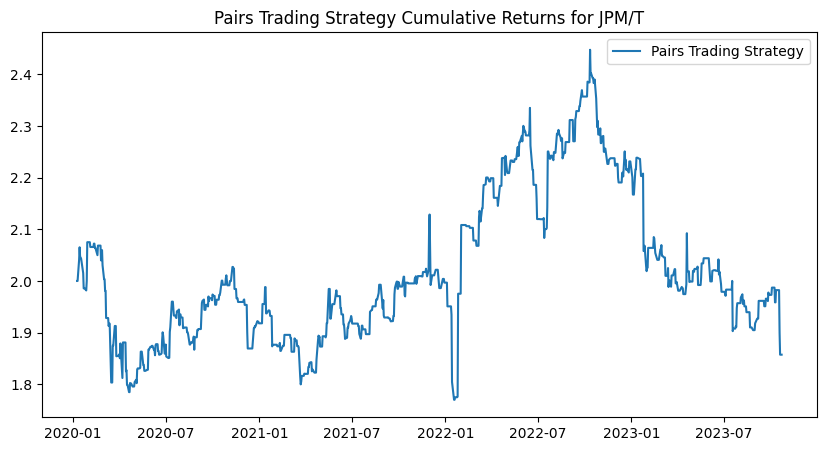

<ipython-input-3-e146cf9b6c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)
<ipython-input-3-e146cf9b6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)


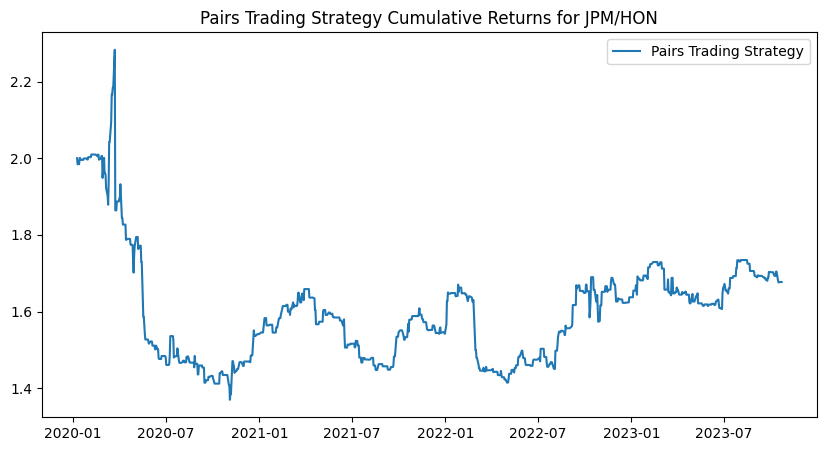

<ipython-input-3-e146cf9b6c0f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)
<ipython-input-3-e146cf9b6c0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)


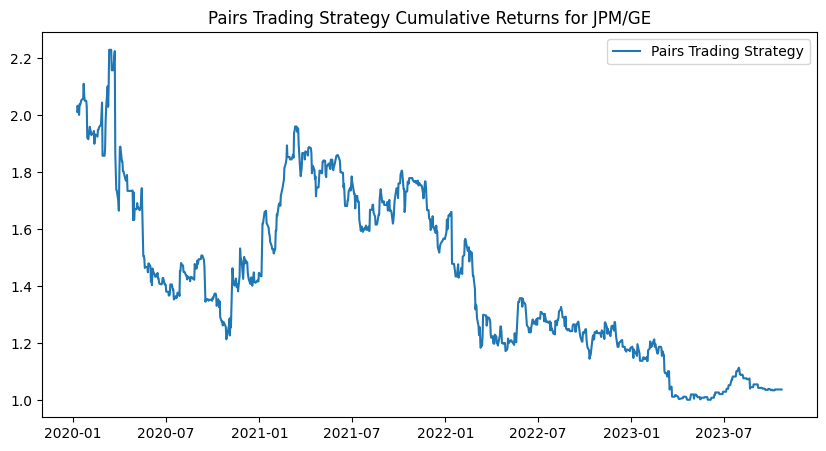

In [ ]:
agent.model.save_weights("path_to_save_your_weights.h5")

# 5. Backtest
def backtest_strategy(stock1_data, stock2_data, signals):
    # Calculate daily returns
    stock1_data['Daily Return'] = stock1_data['Close'].pct_change()
    stock2_data['Daily Return'] = -stock2_data['Close'].pct_change()

    stock1_data['Strategy Return'] = np.nan
    stock1_data['Strategy Return'][N:] = stock1_data['Daily Return'][N:] * np.array(signals)

    stock2_data['Strategy Return'] = np.nan
    stock2_data['Strategy Return'][N:] = stock2_data['Daily Return'][N:] * np.array(signals)

    stock1_data['Cumulative Return'] = (1 + stock1_data['Strategy Return']).cumprod()
    stock2_data['Cumulative Return'] = (1 + stock2_data['Strategy Return']).cumprod()
    portfolio_cumulative_return = stock1_data['Cumulative Return'] + stock2_data['Cumulative Return']

    # Visualize cumulative returns
    plt.figure(figsize=(10,5))
    plt.plot(stock1_data.index[N:], portfolio_cumulative_return[N:], label="Pairs Trading Strategy")
    plt.legend()
    plt.title(f"Pairs Trading Strategy Cumulative Returns for {stock1}/{stock2}")
    plt.show()

# Run backtest
for stock1, stock2 in pairs:
    stock1_data = data[stock1].copy()
    stock2_data = data[stock2].copy()
    backtest_strategy(stock1_data, stock2_data, signals[(stock1, stock2)])

In [ ]:
from MetaTrader5 import MT5Initialize, MT5Shutdown, MT5OrderSend
import MetaTrader5 as mt5

if not MT5Initialize():
    print("Initialize() failed, error code =", mt5.last_error())
    quit()

def trade_mt5(stock1, stock2, action):
    lot = 1  # Ajusta esto según tu necesidad

    if action == 1:  # long stock1/short stock2
        mt5.order_send(symbol=stock1, action=mt5.ORDER_BUY, volume=lot)
        mt5.order_send(symbol=stock2, action=mt5.ORDER_SELL, volume=lot)
    elif action == 2:  # short stock1/long stock2
        mt5.order_send(symbol=stock1, action=mt5.ORDER_SELL, volume=lot)
        mt5.order_send(symbol=stock2, action=mt5.ORDER_BUY, volume=lot)
    # No se hace nada si action == 0 (hold)

try:
    while True:
      for stock1, stock2 in pairs:
          # Obtener los datos más recientes desde MT5
          stock1_rates = mt5.copy_rates_from_pos(stock1, mt5.TIMEFRAME_D1, 0, N+1)
          stock2_rates = mt5.copy_rates_from_pos(stock2, mt5.TIMEFRAME_D1, 0, N+1)

          stock1_data = [rate['close'] for rate in stock1_rates]
          stock2_data = [rate['close'] for rate in stock2_rates]

          state = np.concatenate([stock1_data[:N], stock2_data[:N]])
          state = np.reshape(state, [1, 2*N])

          action = agent.act(state)
          trade_mt5(stock1, stock2, action)

          # Espera un período de tiempo antes de volver a comprobar (p.ej., 1 día)
          time.sleep(24*60*60)
finally:
    MT5Shutdown()



# Para reentrenar a diario el modelo
Cargamos el modelo y añadimos algunos episodios más, no todos.

In [ ]:
# Asume que ya has cargado y preprocesado todos tus datos

# Carga el modelo previamente entrenado
agent.model.load_weights("path_to_your_saved_weights.h5")

# Número de episodios para reentrenamiento
retraining_episodes = 50

for stock1, stock2 in pairs:
    stock1_data = data[stock1]['Close'].values
    stock2_data = data[stock2]['Close'].values

    for _ in range(retraining_episodes):
        state = np.concatenate([stock1_data[:N], stock2_data[:N]])
        state = np.reshape(state, [1, 2*N])
        total_reward = 0
        for t in range(N, len(stock1_data) - 1):
            action = agent.act(state)
            next_state = np.concatenate([stock1_data[t-N+1:t+1], stock2_data[t-N+1:t+1]])
            next_state = np.reshape(next_state, [1, 2*N])
            if action == 1:  # long stock1/short stock2
                reward = stock1_data[t+1] / stock1_data[t] - stock2_data[t+1] / stock2_data[t]
            elif action == 2:  # short stock1/long stock2
                reward = stock2_data[t+1] / stock2_data[t] - stock1_data[t+1] / stock1_data[t]
            else:
                reward = 0
            total_reward += reward
            done = True if t == len(stock1_data) - 2 else False
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.replay()
    print(f"Retraining for pair {stock1}/{stock2} completed!")

# Guarda los pesos del modelo después del reentrenamiento
agent.model.save_weights("path_to_save_your_weights.h5")


# Experimental Setup del PAPER